In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')

In [3]:
np.random.seed(1234)
tf.set_random_seed(1234)


In [71]:
class PI_DeepONet():
    def __init__(self, m, ope_data, phy_data, branch_layer, trunk_layer, lr, activation):
        self.m = m
        self.ope_data = ope_data
        self.phy_data = phy_data
        self.activation = activation
        self.loss_log = []
        self.loss_res_log = []
        self.loss_ope_log = []

        self.branch_layer = branch_layer
        self.trunk_layer  = trunk_layer

        self.sess = tf.Session()
        self.branch_weights, self.branch_biases = self.initilize_NN(branch_layer)
        self.trunk_weights, self.trunk_biases   = self.initilize_NN(trunk_layer)
        self.bias = tf.Variable(tf.zeros([1], dtype=tf.float32), dtype=tf.float32)

        self.u_tf   = tf.placeholder(tf.float32, shape=[None, self.m])
        self.y_tf   = tf.placeholder(tf.float32, shape=[None, 1])
        self.s_tf   = tf.placeholder(tf.float32, shape=[None, 1])
        self.u_r_tf = tf.placeholder(tf.float32, shape=[None, self.m])
        self.y_r_tf = tf.placeholder(tf.float32, shape=[None, 1])
        self.s_r_tf = tf.placeholder(tf.float32, shape=[None, 1])

        self.branch_out = self.neural_net(self.u_tf, self.branch_weights, self.branch_biases, self.activation)
        self.trunk_out  = self.neural_net(self.y_tf, self.trunk_weights, self.trunk_biases, self.activation)
        self.Guy_pred   = tf.reshape(tf.reduce_sum(tf.multiply(self.branch_out, self.trunk_out),
                                                 axis=1) + self.bias, [-1, 1])
        self.s_r           = self.residual_net(self.u_r_tf, self.y_r_tf)
        self.loss_operator = tf.reduce_mean(tf.square(self.Guy_pred - self.s_tf))
        self.loss_residual = tf.reduce_mean(tf.square(self.s_r - self.s_r_tf))
        self.loss = self.loss_operator + self.loss_residual

        steps_per_decay = 1000
        decay_factor = 0.9
        self.global_step = tf.Variable(0, trainable=False)
        self.lr = tf.train.exponential_decay(learning_rate = lr,
                                           global_step = self.global_step,
                                           decay_steps = steps_per_decay,
                                           decay_rate = decay_factor,
                                           staircase = True
                                           )
        self.optimizer = tf.train.AdamOptimizer(learning_rate=self.lr).minimize(self.loss,
                                                            global_step=self.global_step)
        init = tf.global_variables_initializer()
        self.sess.run(init)

    def callback(self, loss, loss_res, loss_ope):
        print('Loss:%f,res:%f,ope:%f'%(loss, loss_res, loss_ope))

    def initilize_NN(self, layers):
        weights = []
        biases  = []
        num_layers = len(layers)
        for l in range(0, num_layers - 1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)
        return weights, biases

    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)

    def neural_net(self, X, weights, biases, activation):
        num_layers = len(weights) + 1
        H = X
        for l in range(0, num_layers - 2):
            W = weights[l]
            b = biases[l]
            H = activation(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y

    def train(self, max_iter=40000, batch_size=50):
        loss_value = np.inf
        lp = np.inf
        lo = np.inf
        for iter in range(max_iter):
            self.sess.run(self.global_step)
            (u, y), s       = self.ope_data.get_batch()
            (u_r, y_r), s_r = self.phy_data.get_batch()
            tf_dict = {
                self.u_tf : u,
                self.y_tf : y,
                self.s_tf : s,
                self.u_r_tf : u_r,
                self.y_r_tf : y_r,
                self.s_r_tf : s_r
            }
            _, loss_value, lp, lo= self.sess.run([self.optimizer,
                self.loss, self.loss_residual, self.loss_operator], tf_dict)
            self.loss_res_log.append(lp)
            self.loss_ope_log.append(lo)
            self.loss_log.append(loss_value)
            self.sess.run(self.lr)
            if iter % 100 == 0:
                print("第%d次 %f,phy %f,ope %f"%(iter, loss_value, lp, lo))
        print("第%d次的损失为%f"%(max_iter, loss_value))
        print("最终lr为%f"%(self.sess.run(self.lr)))

    def predict(self, u, y):
        s = self.sess.run(self.Guy_pred, {self.u_tf: u, self.y_tf:y})
        return s

    def predict_r(self, u_r, y_r):
        s_r = self.sess.run(self.s_r, {self.u_r_tf: u_r, self.y_r_tf:y_r})
        return s_r

    def residual_net(self, u, y):
        branch_out = self.neural_net(u, self.branch_weights, self.branch_biases, self.activation)
        trunk_out  = self.neural_net(y, self.trunk_weights, self.trunk_biases, self.activation)
        Guy = tf.reshape(tf.reduce_sum(tf.multiply(branch_out, trunk_out),
                     axis=1) + self.bias, [-1, 1])
        s_y = tf.gradients(Guy, y)[0]
        return s_y

In [62]:
class DataGenerator():
    def __init__(self, u, y, s, batch_size):
        self.u = u
        self.y = y
        self.s = s
        self.batch_size = batch_size

    def get_batch(self):
        index = np.random.randint(0, self.u.shape[0], self.batch_size)
        u = self.u[index, :]
        y = self.y[index, :]
        s = self.s[index, :]
        inputs = (u, y)
        outputs = s
        return inputs, outputs

In [57]:
# dataset
batch_size = 10000
m = 100
u_train = np.load("./dataset/SifanWang/u_train.npy")
y_train = np.load("./dataset/SifanWang/y_train.npy")
s_train = np.load("./dataset/SifanWang/s_train.npy")
operator_dataset = DataGenerator(u_train, y_train, s_train, batch_size)

In [58]:
u_r_train = np.reshape(np.tile(u_train,(1, m)), (-1, m))
y_r_train = np.load("./dataset/SifanWang/y_r_train.npy")
s_r_train = np.load("./dataset/SifanWang/s_r_train.npy")
residual_dataset = DataGenerator(u_r_train, y_r_train, s_r_train, batch_size)

In [59]:
def plot_loss(model, start, end):
    iter = np.linspace(start, end, end - start)
    plt.plot(iter, np.array(model.loss_log)[start:end])
    plt.yscale('log')
    plt.tight_layout()
    plt.savefig('loss.pdf')

In [72]:
branch_layers = [m, 50, 50, 50, 50, 50]
trunk_layers =  [1, 50, 50, 50, 50, 50]
lr = 1e-3
pi_deepONet_relu = PI_DeepONet(m, operator_dataset, residual_dataset, branch_layers, trunk_layers, lr, tf.nn.relu)

第0次 1.157069,phy 0.979175,ope 0.177895
第100次 0.280884,phy 0.276149,ope 0.004735
第200次 0.075161,phy 0.074149,ope 0.001012
第300次 0.051215,phy 0.050719,ope 0.000496
第400次 0.047294,phy 0.046927,ope 0.000367
第500次 0.023492,phy 0.023194,ope 0.000298
第600次 0.027104,phy 0.026704,ope 0.000400
第700次 0.029346,phy 0.028850,ope 0.000495
第800次 0.020725,phy 0.020502,ope 0.000223
第900次 0.019291,phy 0.019125,ope 0.000166
第1000次 0.021598,phy 0.021359,ope 0.000239
第1100次 0.025853,phy 0.025624,ope 0.000229
第1200次 0.030336,phy 0.030022,ope 0.000314
第1300次 0.024685,phy 0.024559,ope 0.000126
第1400次 0.023325,phy 0.023027,ope 0.000298
第1500次 0.029681,phy 0.029343,ope 0.000338
第1600次 0.031092,phy 0.030756,ope 0.000337
第1700次 0.020670,phy 0.020315,ope 0.000354
第1800次 0.031281,phy 0.031084,ope 0.000197
第1900次 0.034415,phy 0.033922,ope 0.000494
第2000次 0.024687,phy 0.024471,ope 0.000216
第2100次 0.027146,phy 0.026926,ope 0.000220
第2200次 0.026148,phy 0.025953,ope 0.000196
第2300次 0.019680,phy 0.019425,ope 0.000255
第240

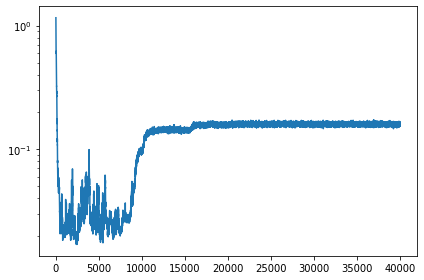

In [73]:
start_time = time.time()
pi_deepONet_relu.train(max_iter=40000, batch_size=batch_size)
elapsed = time.time() - start_time
print('Training time: %.4f' % (elapsed))
plot_loss(pi_deepONet_relu, 0, 40000)


In [74]:
s_pred = pi_deepONet_relu.predict(u_train, y_train)
error_s = np.linalg.norm(s_train - s_pred) / np.linalg.norm(s_train)
print(error_s)

0.0873294


In [75]:
u = np.load("./dataset/SifanWang/u_test.npy")
y = np.load("./dataset/SifanWang/y_test.npy")
s = np.load("./dataset/SifanWang/s_test.npy")
error = []
for i in range(u.shape[0]):
    s_pred = pi_deepONet_relu.predict(u[i], y[i])
    error.append(np.linalg.norm(s_pred - s[i])/np.linalg.norm(s[i]))
error = np.array(error)
print(error.mean())
print(error.std())

0.13330041
0.11480911


第0次 1.054886,phy 0.904056,ope 0.150830
第100次 0.313475,phy 0.306843,ope 0.006632
第200次 0.134985,phy 0.132361,ope 0.002624
第300次 0.061802,phy 0.060006,ope 0.001796
第400次 0.046142,phy 0.045200,ope 0.000941
第500次 0.037766,phy 0.037033,ope 0.000733
第600次 0.017769,phy 0.017276,ope 0.000493
第700次 0.014757,phy 0.014438,ope 0.000319
第800次 0.014090,phy 0.013815,ope 0.000275
第900次 0.013036,phy 0.012811,ope 0.000225
第1000次 0.011935,phy 0.011784,ope 0.000151
第1100次 0.012114,phy 0.011970,ope 0.000144
第1200次 0.012255,phy 0.012107,ope 0.000149
第1300次 0.012388,phy 0.012091,ope 0.000297
第1400次 0.011337,phy 0.011187,ope 0.000150
第1500次 0.010572,phy 0.010363,ope 0.000209
第1600次 0.007103,phy 0.006941,ope 0.000162
第1700次 0.004760,phy 0.004584,ope 0.000177
第1800次 0.004378,phy 0.004220,ope 0.000158
第1900次 0.004419,phy 0.004198,ope 0.000221
第2000次 0.005097,phy 0.004745,ope 0.000352
第2100次 0.003236,phy 0.003179,ope 0.000057
第2200次 0.003447,phy 0.003364,ope 0.000083
第2300次 0.002879,phy 0.002816,ope 0.000063
第240

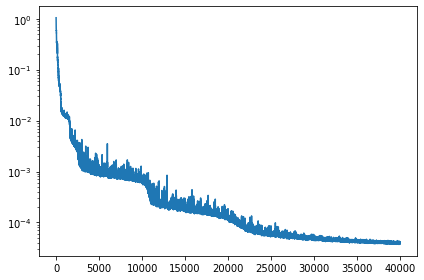

In [79]:
branch_layers = [m, 50, 50, 50, 50, 50]
trunk_layers =  [1, 50, 50, 50, 50, 50]
'''
branch_layers = [m, 100, 100]
trunk_layers =  [1, 100, 100] # 效果不好
'''
lr = 1e-3
pi_deepONet_relu = PI_DeepONet(m, operator_dataset, residual_dataset, branch_layers, trunk_layers, lr, tf.tanh)
start_time = time.time()
pi_deepONet_relu.train(max_iter=40000, batch_size=batch_size)
elapsed = time.time() - start_time
print('Training time: %.4f' % (elapsed))
plot_loss(pi_deepONet_relu, 0, 40000)

In [80]:
error = []
for i in range(u.shape[0]):
    s_pred = pi_deepONet_relu.predict(u[i], y[i])
    error.append(np.linalg.norm(s_pred - s[i])/np.linalg.norm(s[i]))
error = np.array(error)
print(error.mean())
print(error.std())


0.0028141155
0.0024218871
